### How has the predominant emotional tone changed over time within each genre? 

First lets do a general analysis of how the overall emotional tone had changed over time 

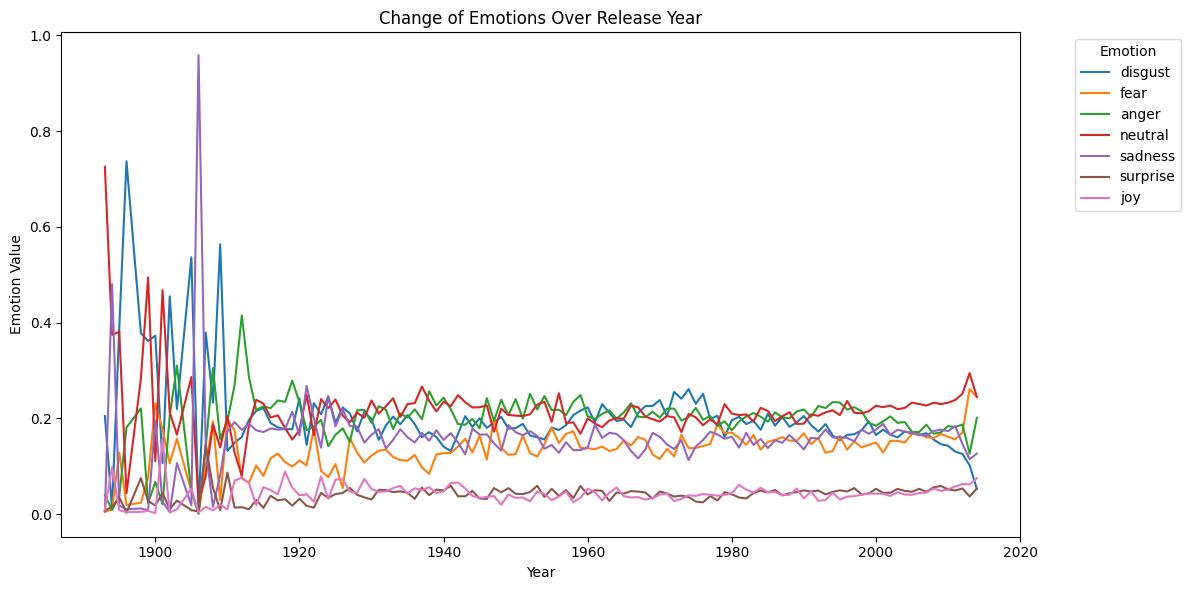

In [2]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

sys.path.append("../")
from utils.methods import conv_to_dict

df = pd.read_csv("../../data/final_data_complete.csv")

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)

emotions_df['merge_year'] = emotions_df['merge_year'].astype("Int64")


emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

temp = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()


temp.columns = ['merge_year'] + emotions

long_df = pd.melt(temp, id_vars=["merge_year"], 
                  var_name="Emotion", 
                  value_name="Value")

plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df, x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### We can a very high variance in the emotional tone in the film made prior to 1925. This can be attributed to the fact that we have very few films from that era in our dataset and the plot summaries are not enough to get a good idea of the emotional tone of the film.

##### So we decided to escude the films made prior to 1925 and focus on the films made after 1925.

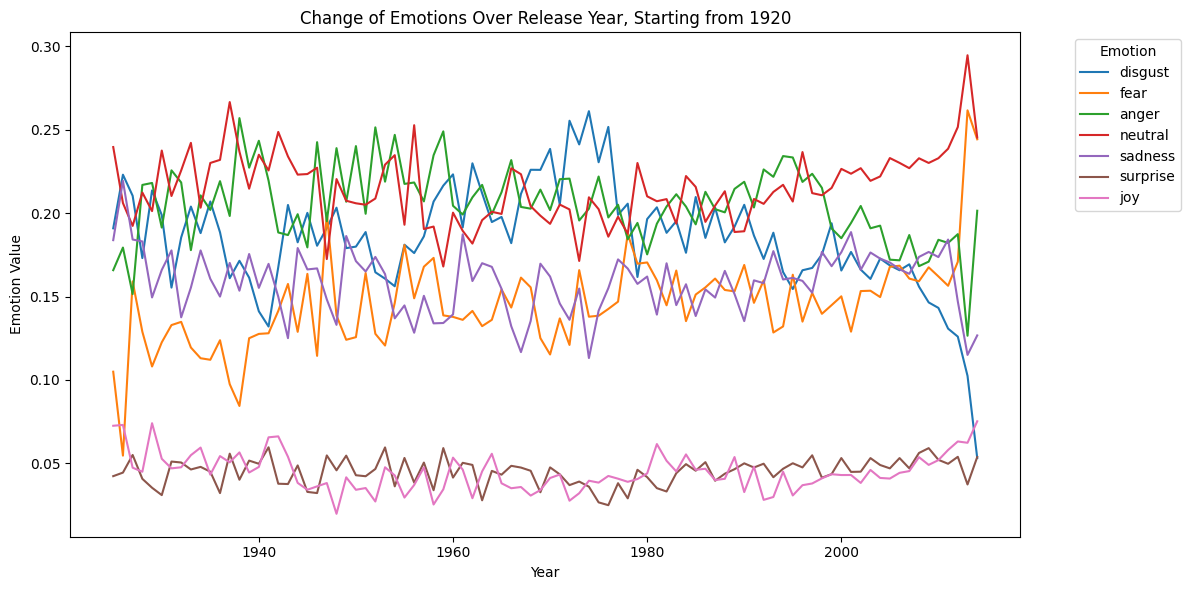

In [3]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df[long_df['merge_year'] >= 1925], x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year, Starting from 1920")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### Now the plot is way more clear, we can see emotional tones overall seems to be quite stationary over time except few exceptions.

##### That pattern seems to have change in recent years, where we see drastic changes in the most of emotions after the year 2000.

##### Lets go deeper now and see how the predominant emotions have changed over time within each genre.

In [4]:
# Import the dataset from the cleaning part of the Question 1 script
emotions_df = pd.read_csv("../../data/emotions_timeseries.csv")

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

grouped_df = emotions_df.groupby(['Genres', 'merge_year'])[emotions].mean().reset_index()

genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World Cinema": ["sadness", "disgust"]
}

filtered_df = grouped_df[(grouped_df["Genres"].isin(genres_emotions_mapping.keys())) & (grouped_df["merge_year"] >= 1925)]
filtered_df

,Genres,merge_year,disgust,fear,anger,neutral,sadness,surprise,joy
4,Action,1925.0,0.132188,0.154740,0.532814,0.071124,0.058418,0.044134,0.006582
5,Action,1926.0,0.035848,0.007356,0.077189,0.435834,0.031534,0.015973,0.396268
6,Action,1927.0,0.057605,0.231175,0.195570,0.265462,0.227453,0.014149,0.008586
7,Action,1928.0,0.100966,0.081663,0.244840,0.138429,0.393080,0.022458,0.018564
8,Action,1929.0,0.102681,0.078894,0.397675,0.298218,0.111910,0.007414,0.003208
...,...,...,...,...,...,...,...,...,...
1411,Thriller,2009.0,0.163573,0.234907,0.220487,0.179667,0.135361,0.049603,0.016402
1412,Thriller,2010.0,0.183636,0.233520,0.264561,0.162729,0.099979,0.041078,0.014498
1413,Thriller,2011.0,0.156723,0.246248,0.242392,0.173810,0.117400,0.038581,0.024847
1414,Thriller,2012.0,0.171317,0.267541,0.244809,0.152637,0.076240,0.064708,0.022749


In [5]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = filtered_df[filtered_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_df = genre_dataframes["Action"]
comedy_df = genre_dataframes["Comedy"]
crime_fiction_df = genre_dataframes["Crime Fiction"]
drama_df = genre_dataframes["Drama"]
family_film_df = genre_dataframes["Family Film"]
horror_df = genre_dataframes["Horror"]
indie_df = genre_dataframes["Indie"]
romance_film_df = genre_dataframes["Romance Film"]
thriller_df = genre_dataframes["Thriller"]
world_cinema_df = genre_dataframes["World Cinema"]

### Action movies Time Series Analysis

In [44]:
#Function for the box and jenkins procedure
import itertools
import warnings
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def box_jenkins_procedure(data: pd.DataFrame, genre: str):
    tones = data.columns[1:]
    arima_results = {}
    warnings.filterwarnings("ignore")
    for tone in tones:
        print("##########################################\n",
              f"Performing Box-Jenkins Procedure for {tone} in {genre} Genre")
        series = data[tone]
        adf = adfuller(series)
        print(f"ADF Statistic: {adf[0]}")
        print(f"p-value: {adf[1]}")
        d = 0
        if adf[1] > 0.05:
            print("The series is not stationary and needs to be differenced.")
            series = series.diff().reset_index(drop=True).dropna()
            d = 1
        
        p = range(1,4) # 1,2,3
        q = range(0,3) # 0,1,2
        best_aic = np.inf
        best_order = None
        best_model = None

        for p, q in itertools.product(p,q):
            model = ARIMA(series, order=(p,d,q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p,d,q)
                best_model = result
        print(f"Best ARIMA Order for {tone} in {genre} Genre: {best_order}")
        arima_results[tone] = best_model
    return arima_results


def timeseries_plots(data: pd.DataFrame, genre: str):
    tones = data.columns[1:]
    palette = sns.color_palette("bright", len(tones))

    plt.figure(figsize=(12, 6))
    for tone, color in zip(tones, palette):
        sns.lineplot(data=data, x="merge_year", y=tone, label=tone, color= color)
    plt.title(f"{genre} Emotions Over Time")
    plt.xlabel("Year")
    plt.ylabel("Emotion Value")
    plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.grid()
    plt.show()

    for tone, color in zip(tones, palette):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plot_acf(data[tone], lags = 20, ax = axes[0], title = f"ACF of {tone} in {genre} Genre", color = color)
        plot_pacf(data[tone], lags = 20, ax = axes[1], title = f"PACF of {tone} in {genre} Genre", color = color)

        axes[0].lines[0].set_color(color)  
        axes[1].lines[0].set_color(color)
        plt.tight_layout()
        plt.show()

def forecast_series(data: pd.DataFrame, genre: str, results: dict):

    tones = data.columns[1:]  
    palette = sns.color_palette("bright", len(tones))  
    forecast_steps = 5
    future_years = [data["merge_year"].iloc[-1] + i for i in range(1, forecast_steps + 1)]
    
  
    forecast_df = data.copy()
    
    for tone, color in zip(tones, palette):
        if tone not in results:
            print(f"Warning: No ARIMA model found for {tone}. Skipping.")
            continue
        
        best_model = results[tone]  
        series = data[tone].dropna() 

        
        forecast = best_model.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()

        
        new_rows = pd.DataFrame({
            "merge_year": future_years,
            tone: forecast_mean
        })
        forecast_df = pd.concat([forecast_df, new_rows], ignore_index=True)

      
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=data, x="merge_year", y=tone, label=f"Original {tone}", color=color)
        sns.lineplot(
            x=future_years,
            y=forecast_mean,
            label=f"Forecast {tone}",
            color=color,
            linestyle="--"
        )
        plt.fill_between(
            future_years,
            forecast_ci.iloc[:, 0],
            forecast_ci.iloc[:, 1],
            color=color,
            alpha=0.2,
            label=f"Confidence Interval ({tone})"
        )
        plt.title(f"{tone.capitalize()} Forecast for {genre} Genre")
        plt.xlabel("Year")
        plt.ylabel("Emotion Value")
        plt.legend(title="Tone", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid()
        plt.show()
    
    return forecast_df


    

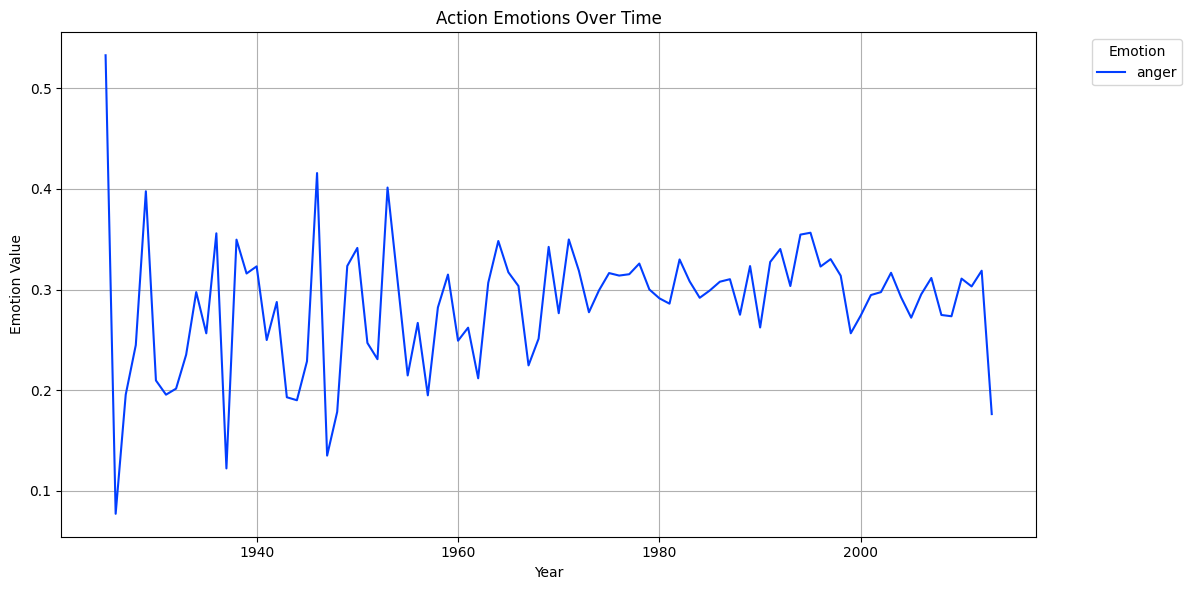

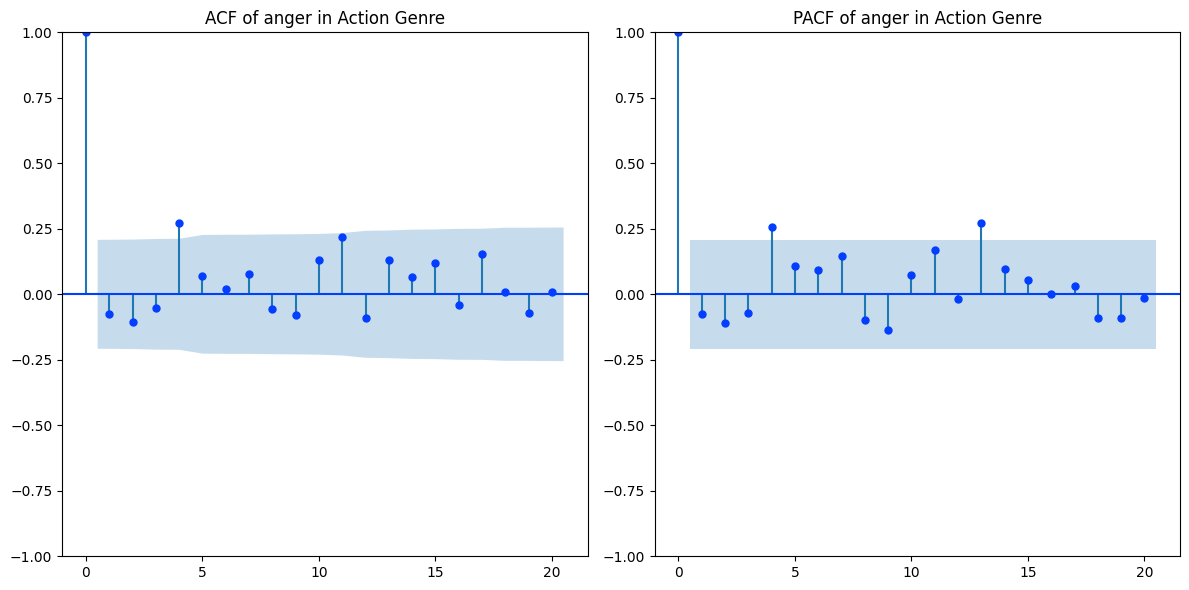

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.807989029390175
p-value: 0.37650263791708827
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 2)


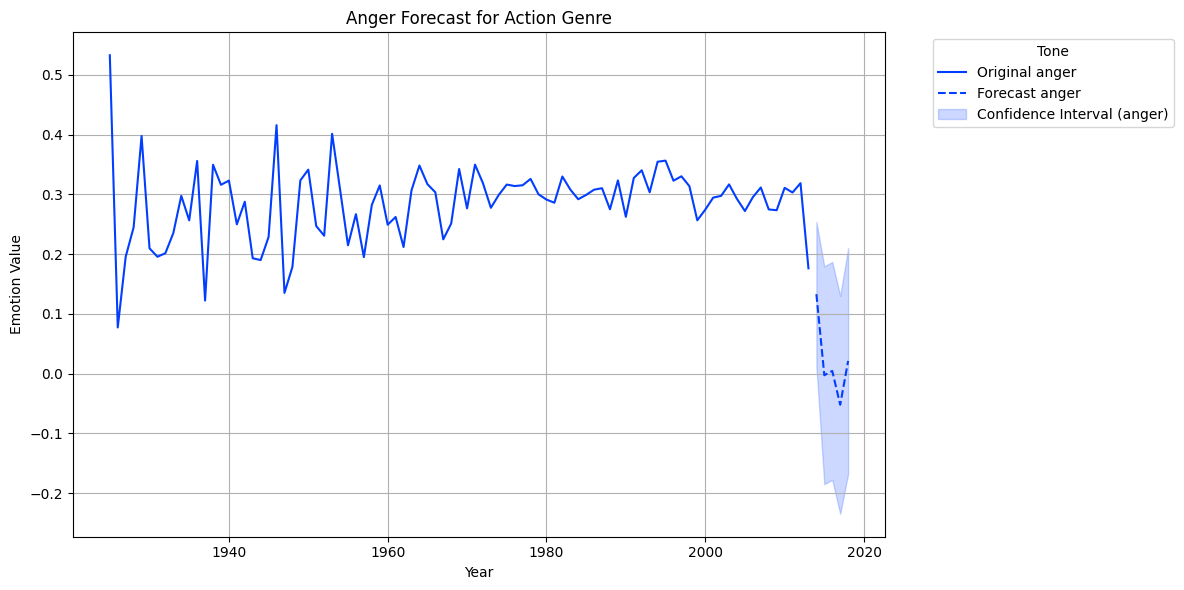

In [45]:

timeseries_plots(action_df, "Action")
action_ts_results = box_jenkins_procedure(action_df, "Action")
action_forecast_df = forecast_series(action_df, "Action", action_ts_results)


### Comedy movies Time Series Analysis

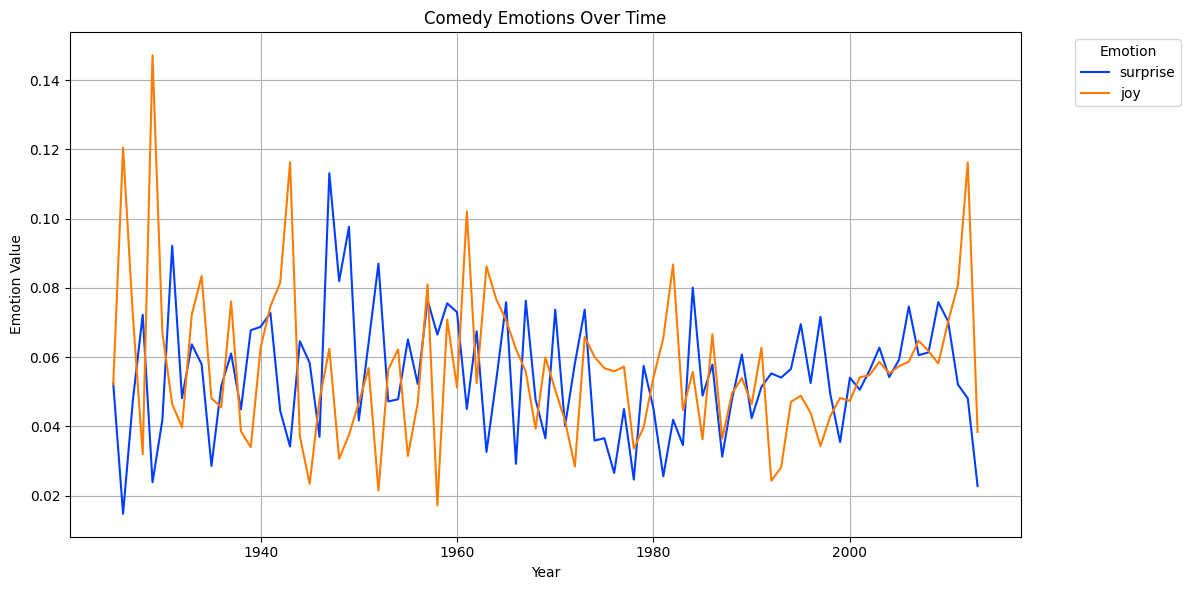

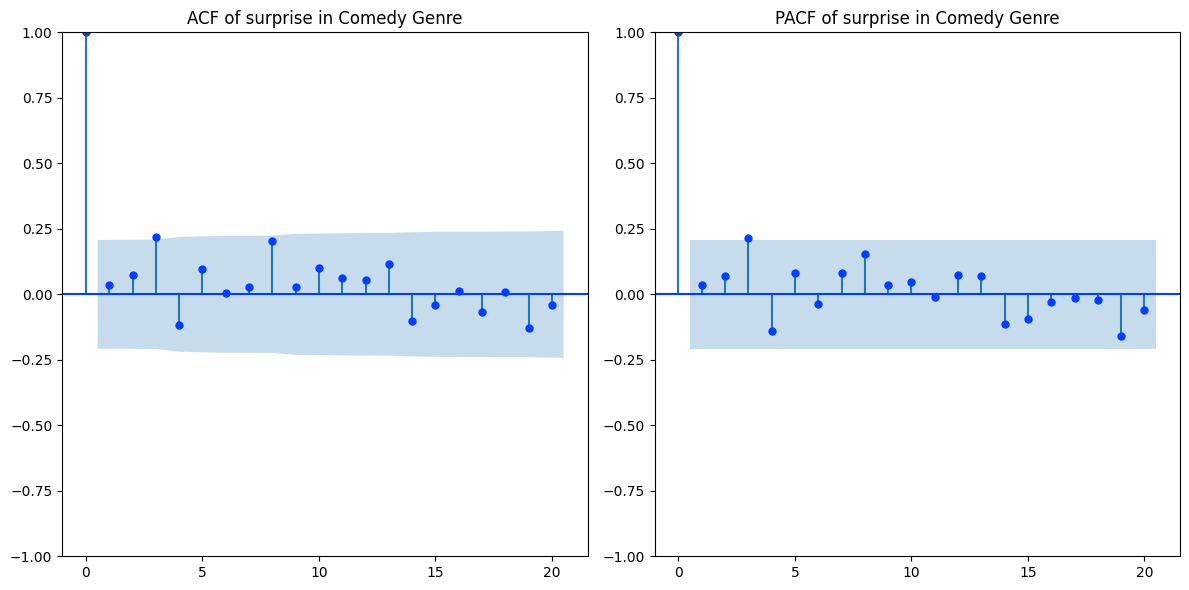

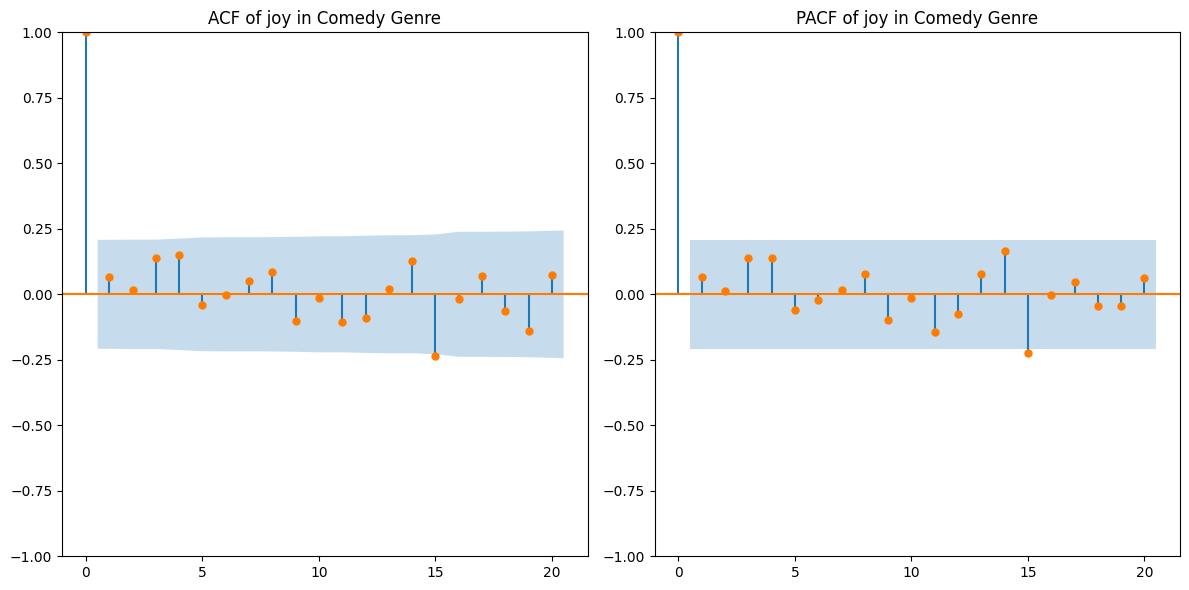

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -5.968435648176734
p-value: 1.9622638574290228e-07
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.658281757117988
p-value: 4.900829802721451e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


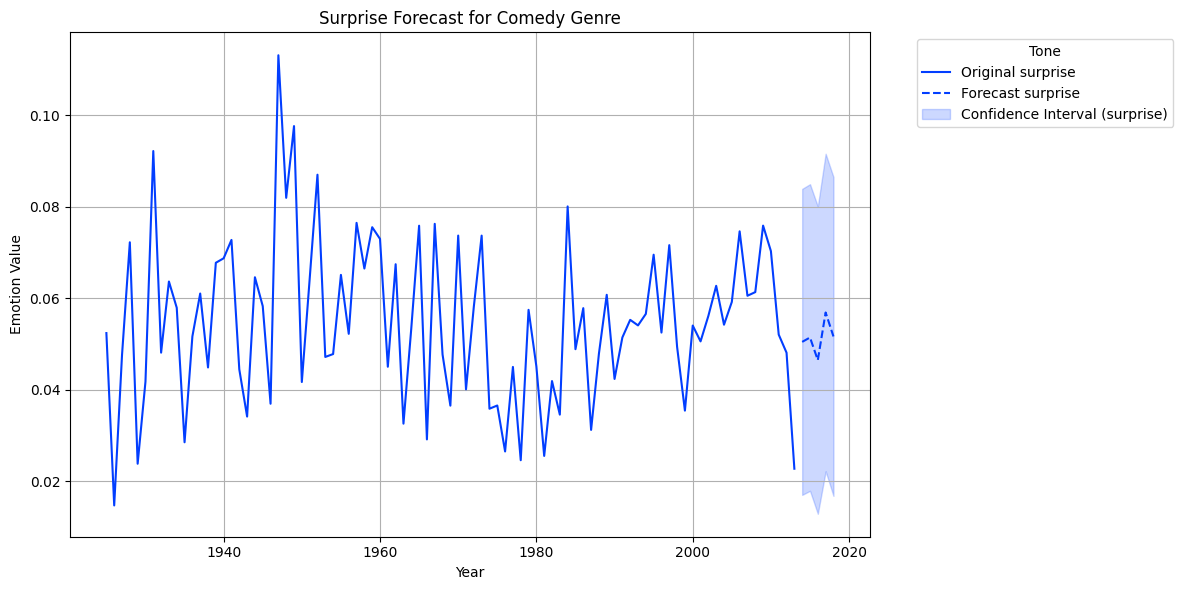

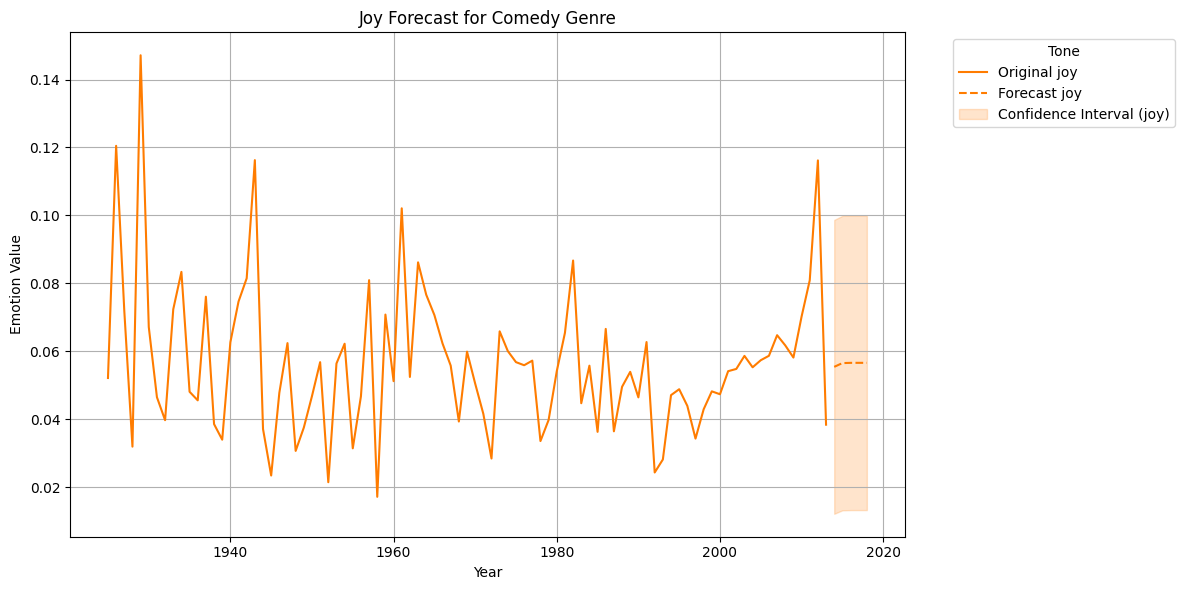

In [46]:
timeseries_plots(comedy_df, "Comedy")
comedy_ts_results = box_jenkins_procedure(comedy_df, "Comedy")
comedy_forecast_df = forecast_series(comedy_df, "Comedy", comedy_ts_results)

### Crime Fiction movies Time Series Analysis

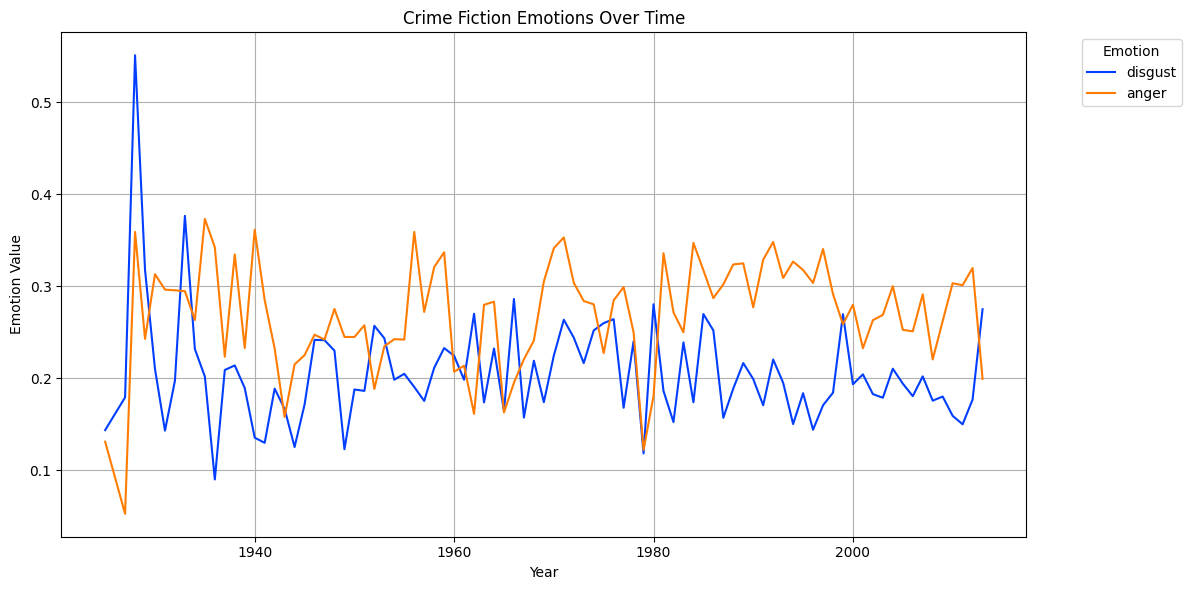

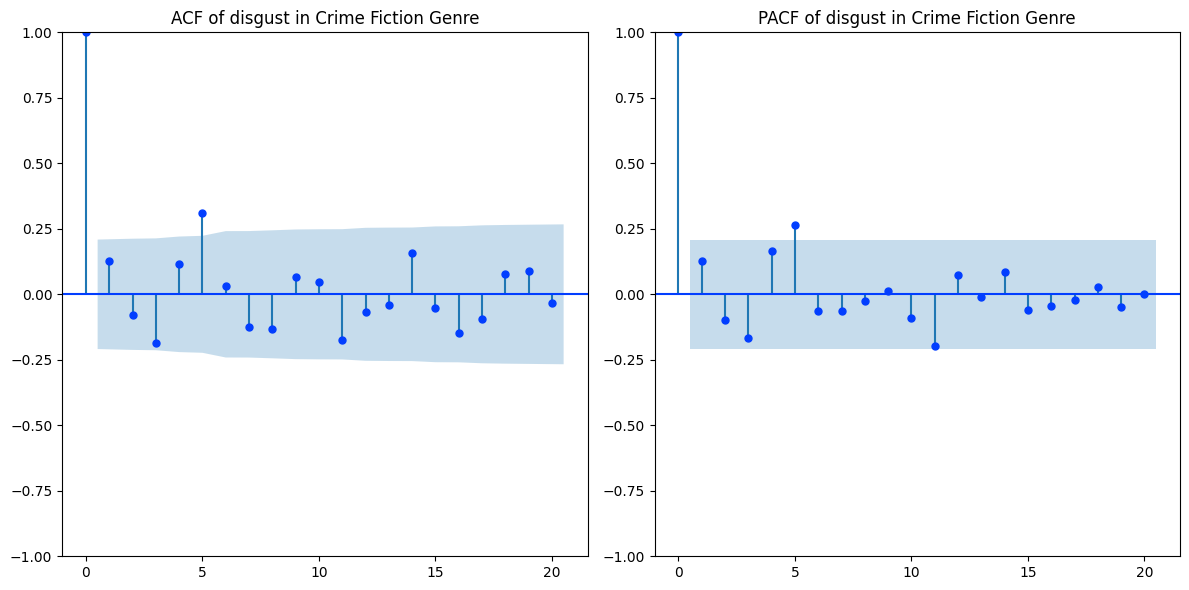

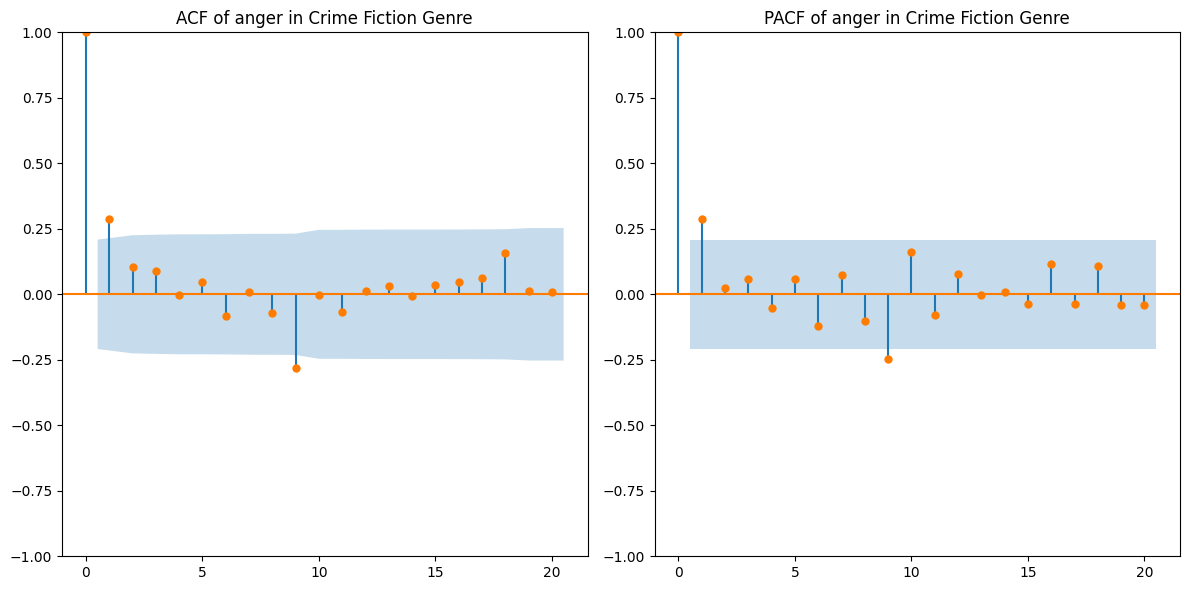

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -8.088848865872588
p-value: 1.3958680299989276e-12
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -7.016935207314902
p-value: 6.695185726922344e-10
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


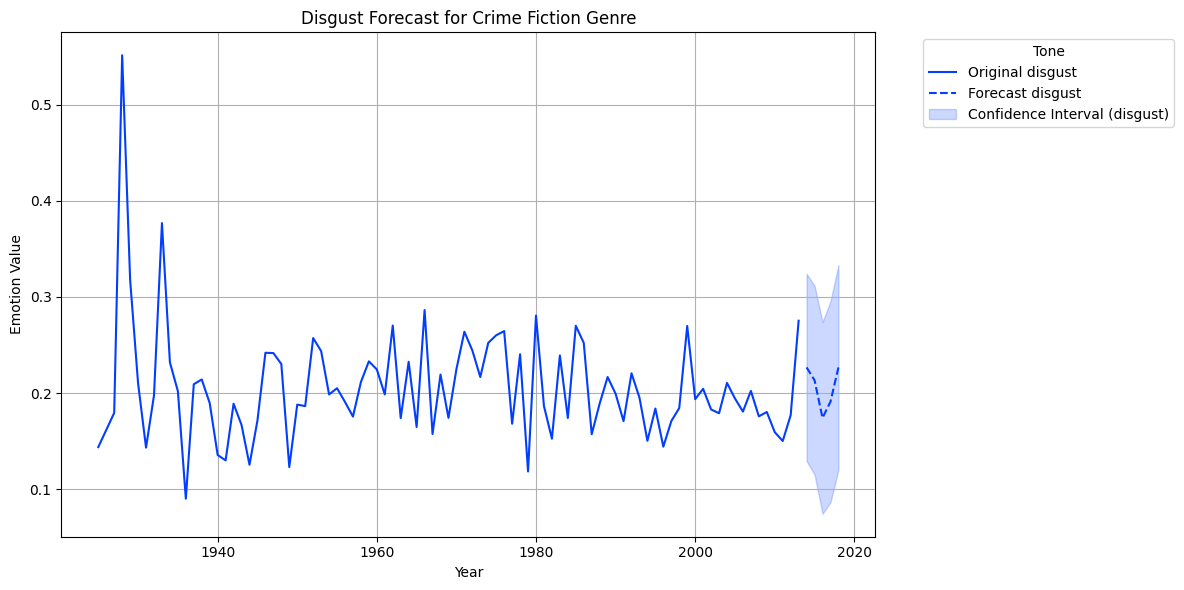

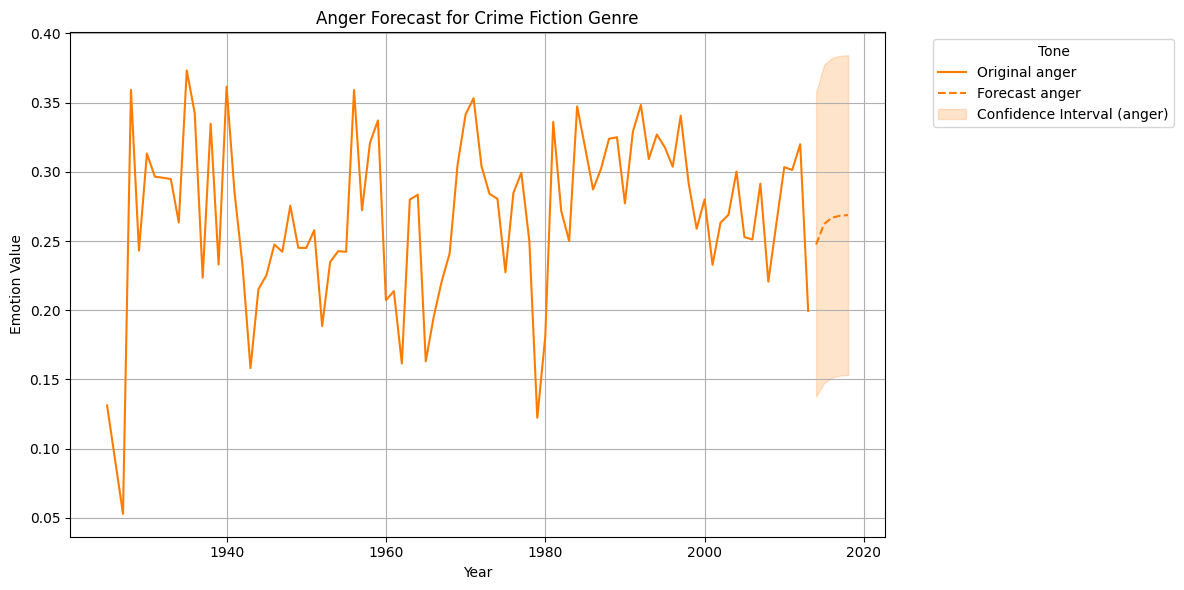

In [47]:
timeseries_plots(crime_fiction_df, "Crime Fiction")
crime_fiction_ts_results = box_jenkins_procedure(crime_fiction_df, "Crime Fiction")
crime_fiction_forecast_df = forecast_series(crime_fiction_df, "Crime Fiction", crime_fiction_ts_results)

## Drama movies Times Series Analysis

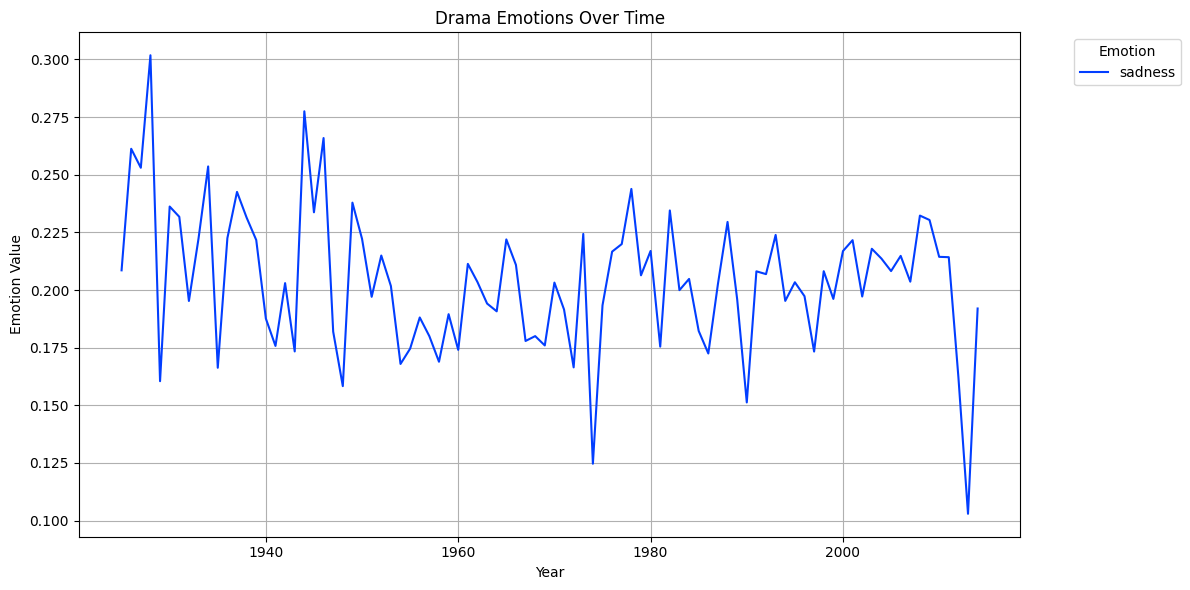

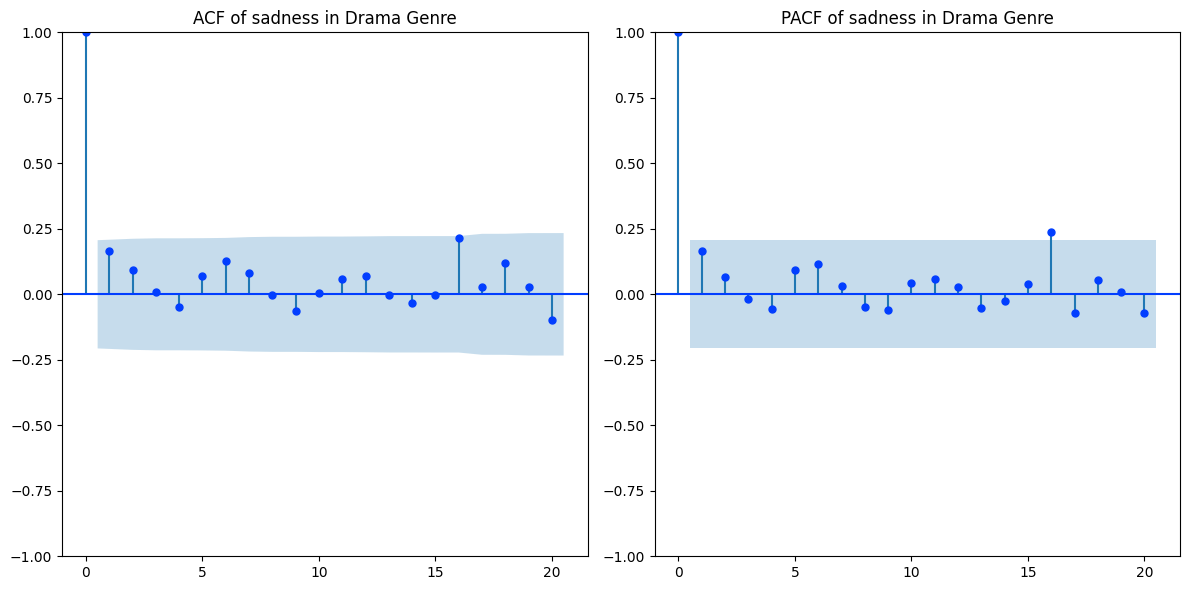

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -7.8999742368599275
p-value: 4.210650740919552e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 0)


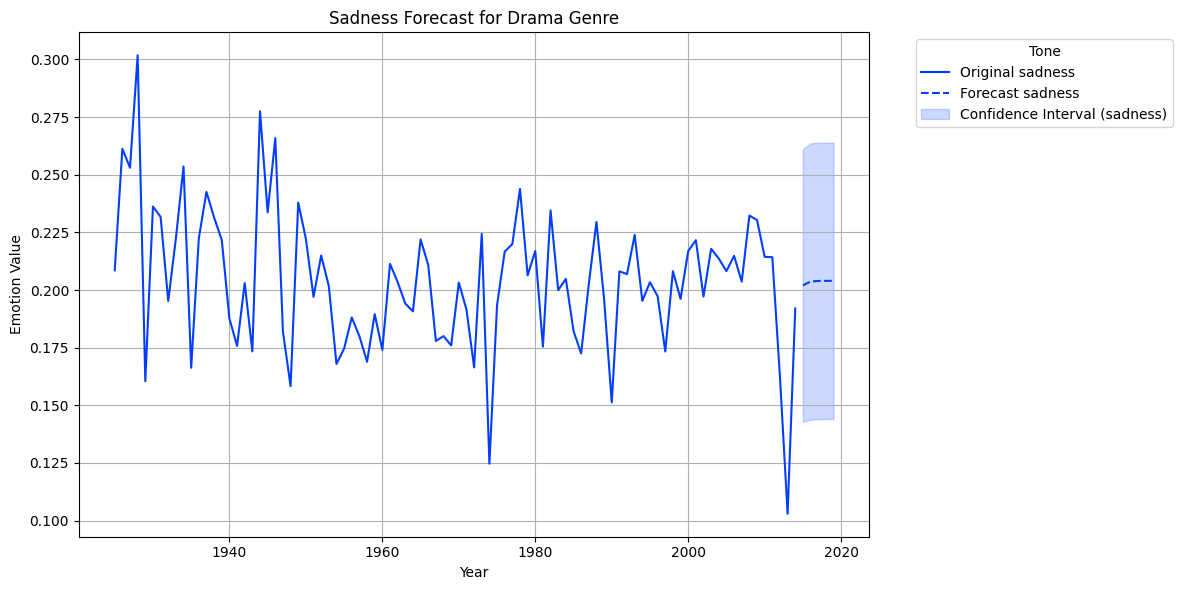

In [48]:
timeseries_plots(drama_df, "Drama")
drama_ts_results = box_jenkins_procedure(drama_df, "Drama")
drama_forecast_df = forecast_series(drama_df, "Drama", drama_ts_results)

## Family Film movies Time Series Analysis

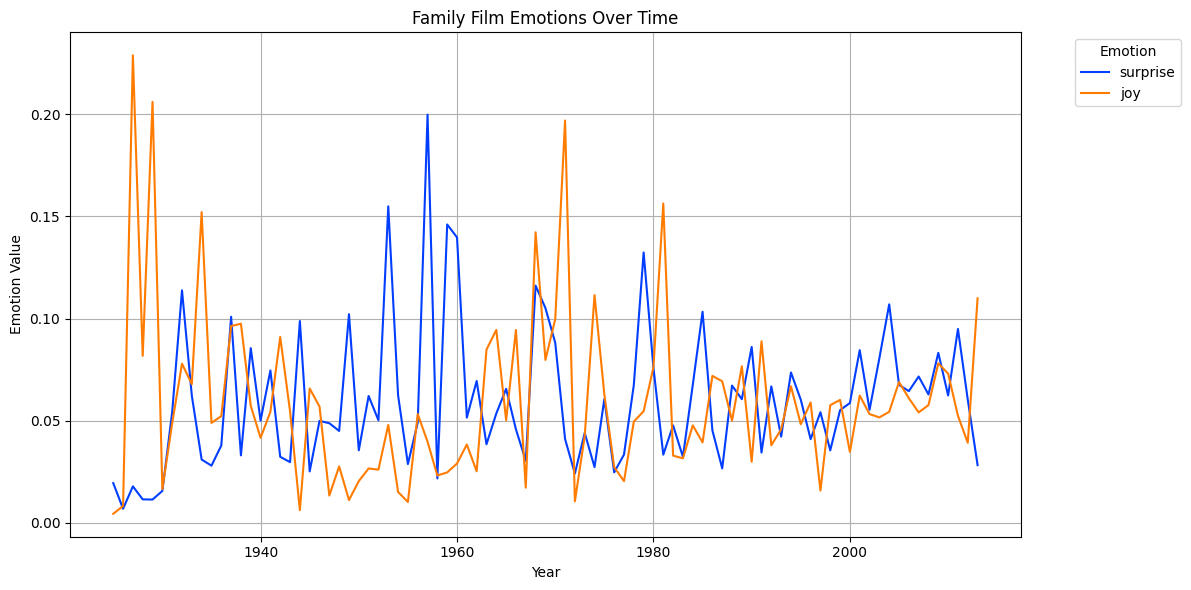

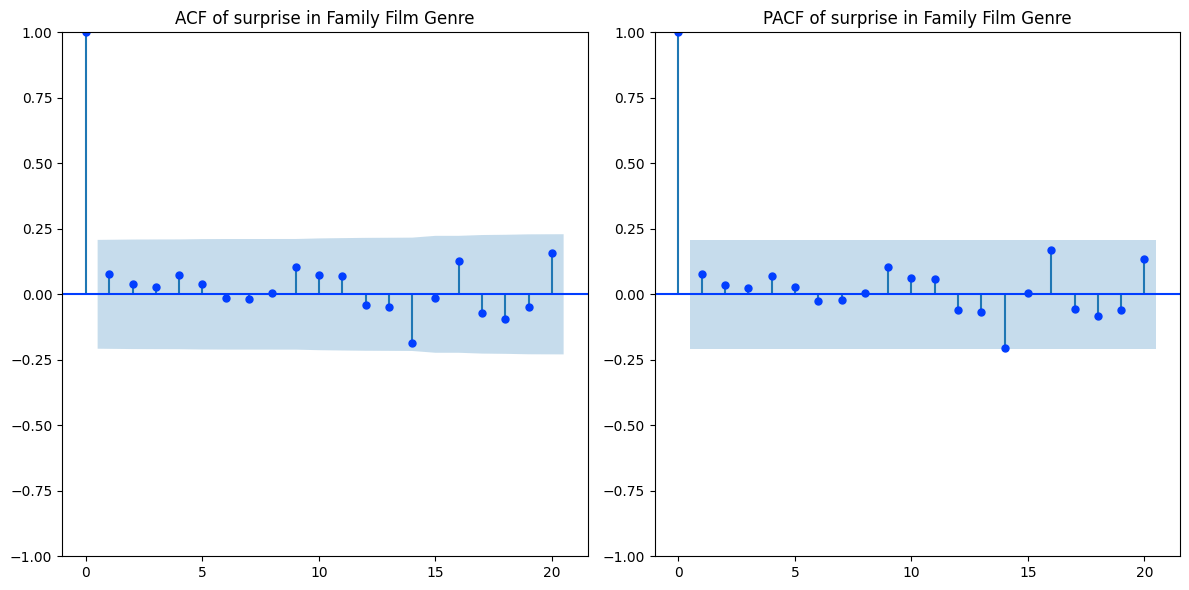

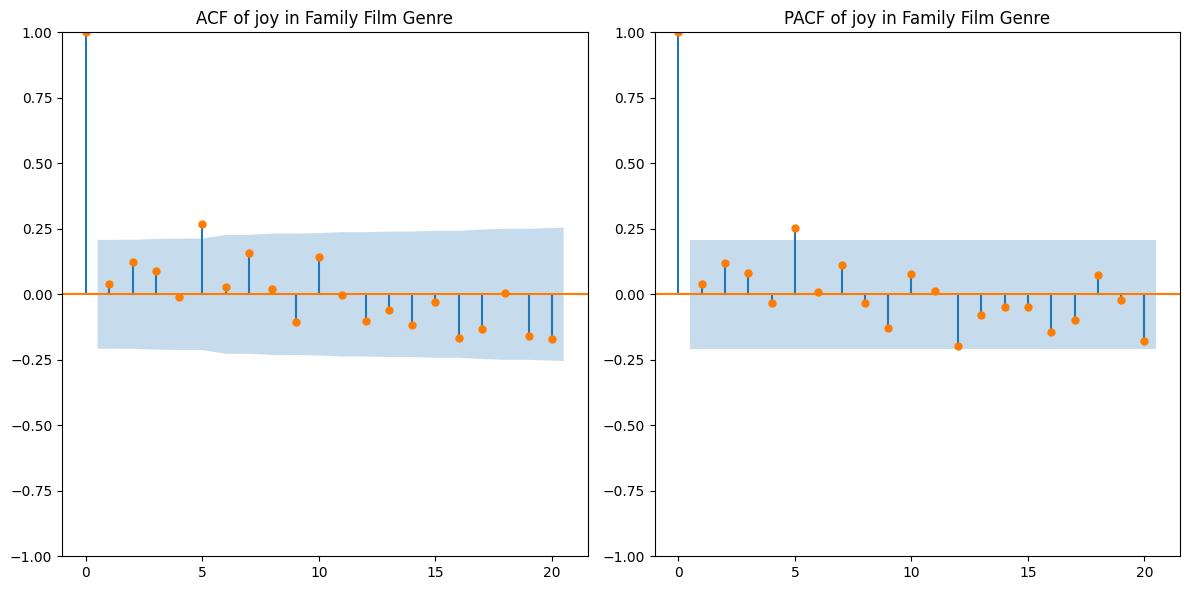

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.589156271860148
p-value: 7.366332903072838e-14
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.314423959836044
p-value: 0.0004193463112126421
Best ARIMA Order for joy in Family Film Genre: (1, 0, 1)


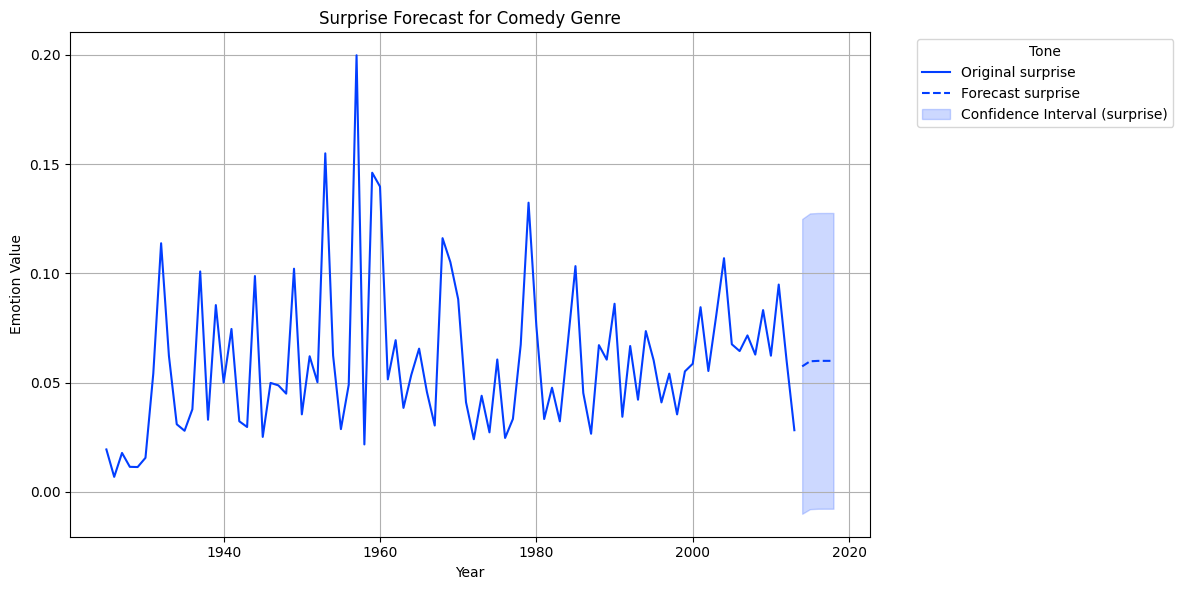

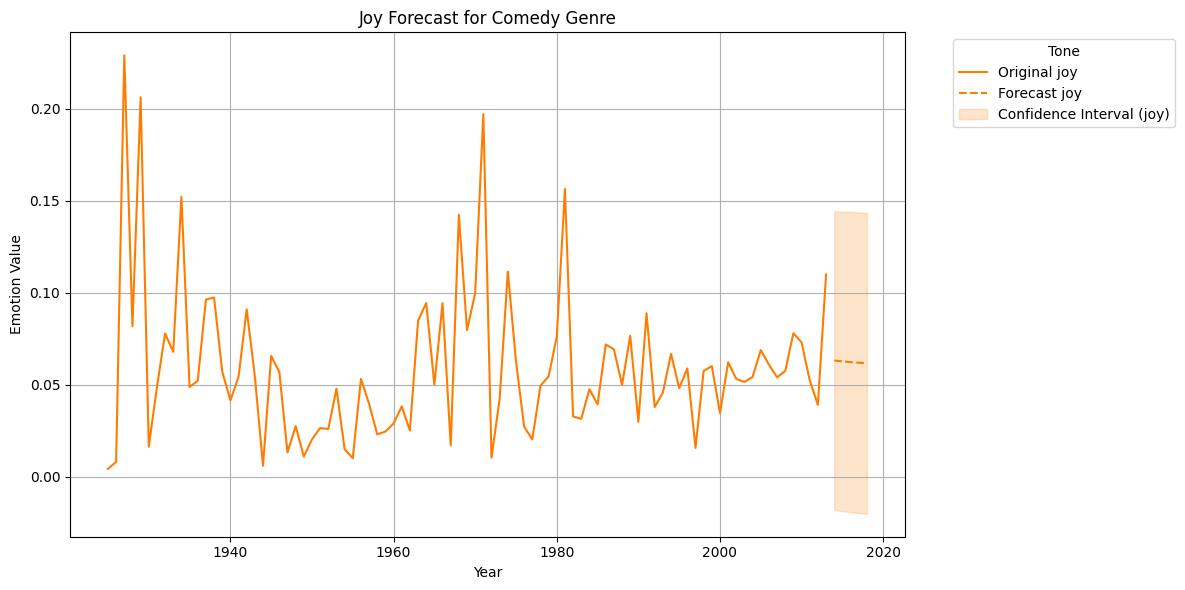

In [ ]:
timeseries_plots(family_film_df, "Family Film")
family_ts_results = box_jenkins_procedure(family_film_df, "Family Film")
family_forecast_df = forecast_series(family_film_df, "Family Film", family_ts_results)

## Horror movies Times Series Analysis

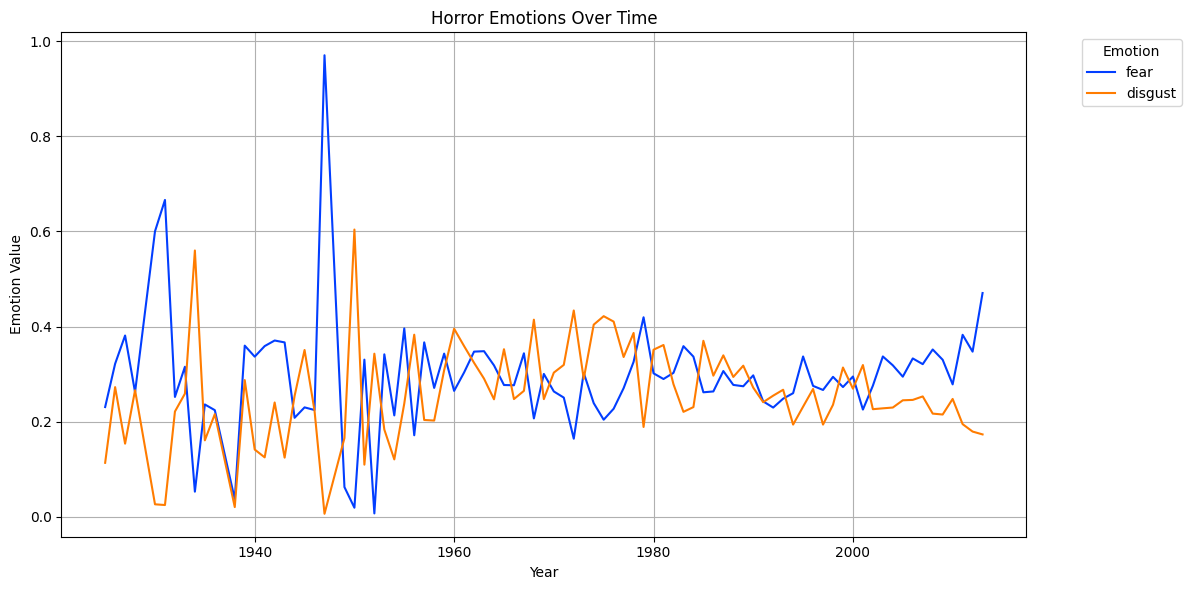

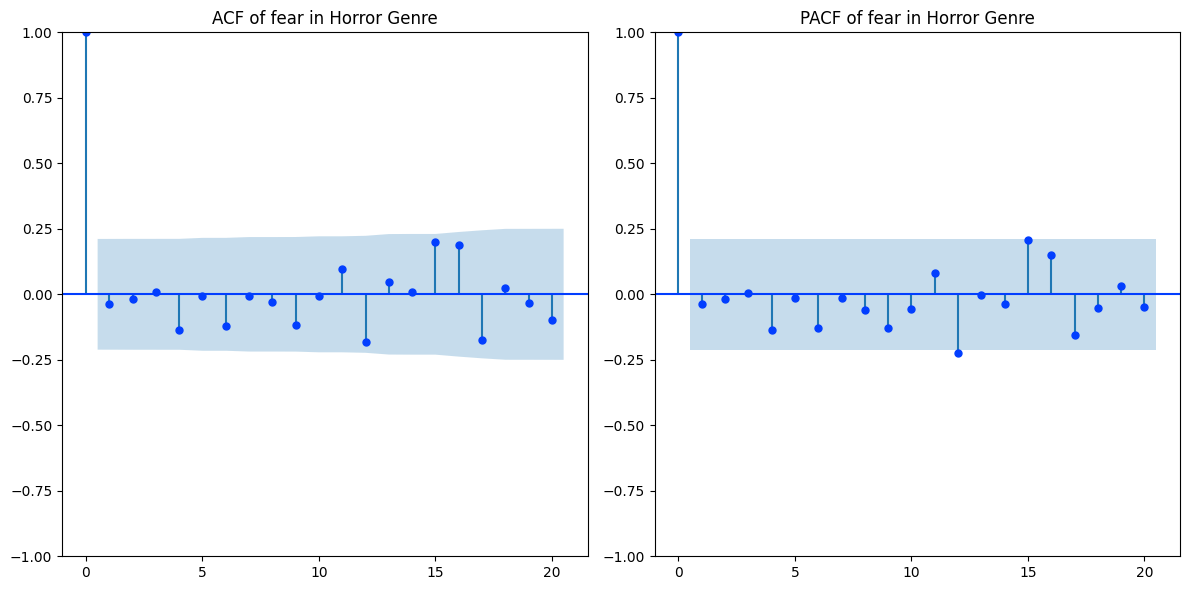

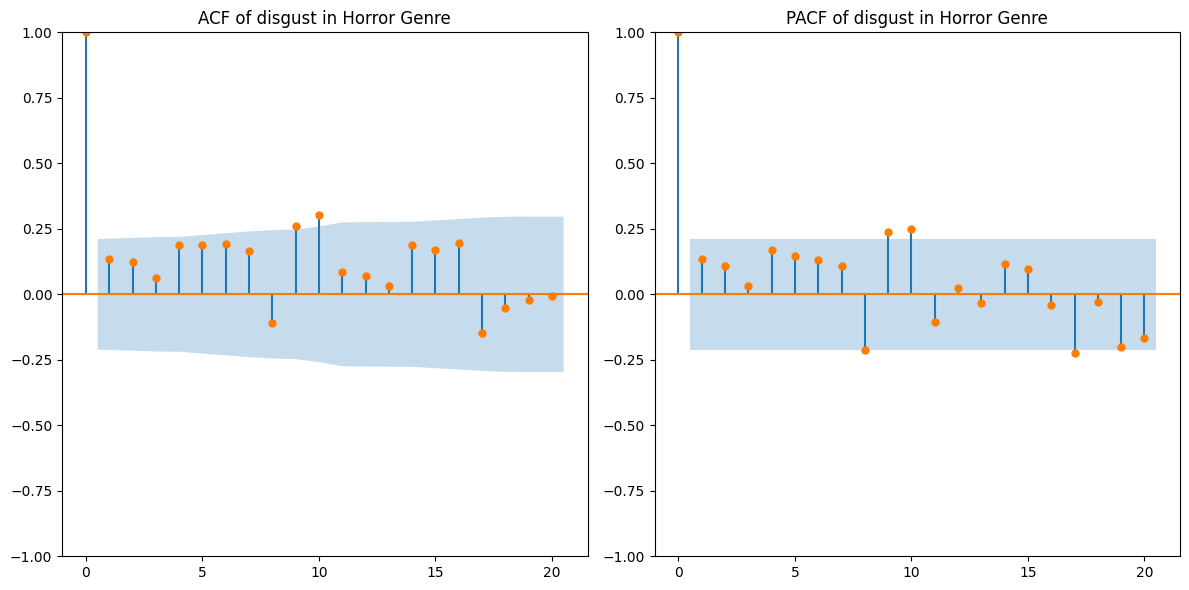

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.348787651757279
p-value: 8.404793853539018e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -0.9412000823129758
p-value: 0.7741021417997707
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 2)


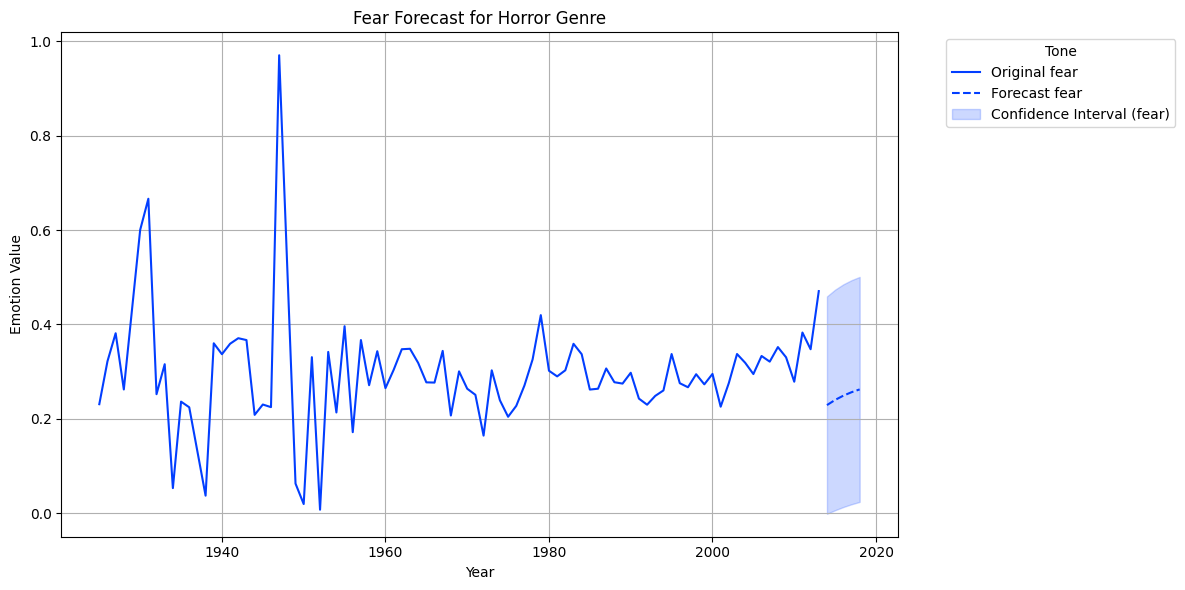

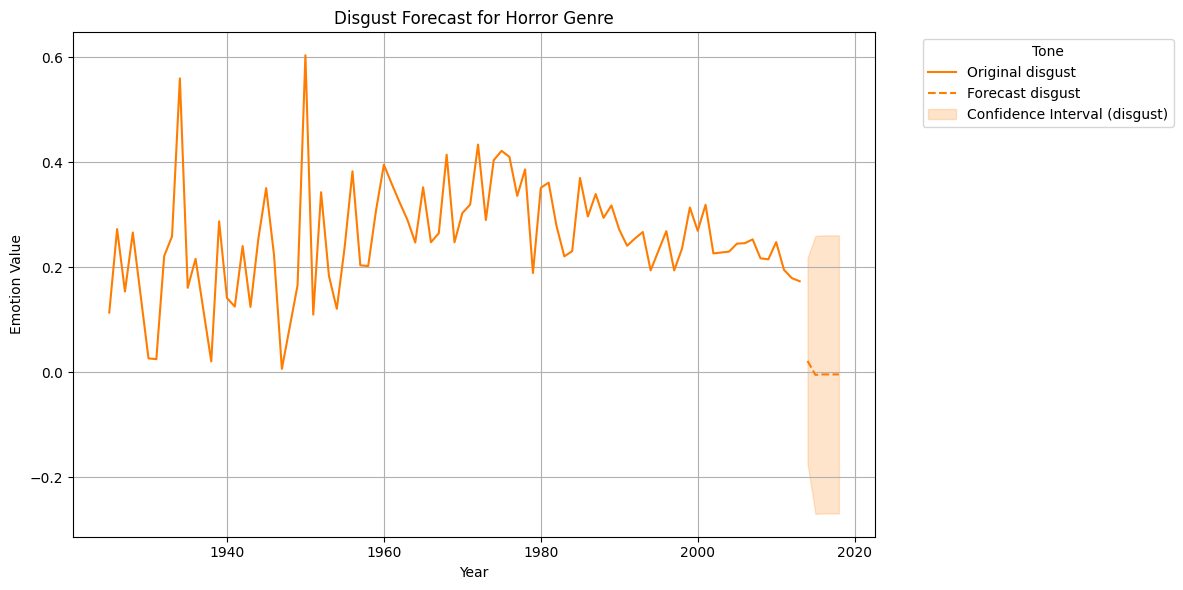

In [50]:
timeseries_plots(horror_df, "Horror")
horror_ts_results = box_jenkins_procedure(horror_df, "Horror")
horror_forecast_df = forecast_series(horror_df, "Horror", horror_ts_results)

## Indie movies Time Series Analysis 

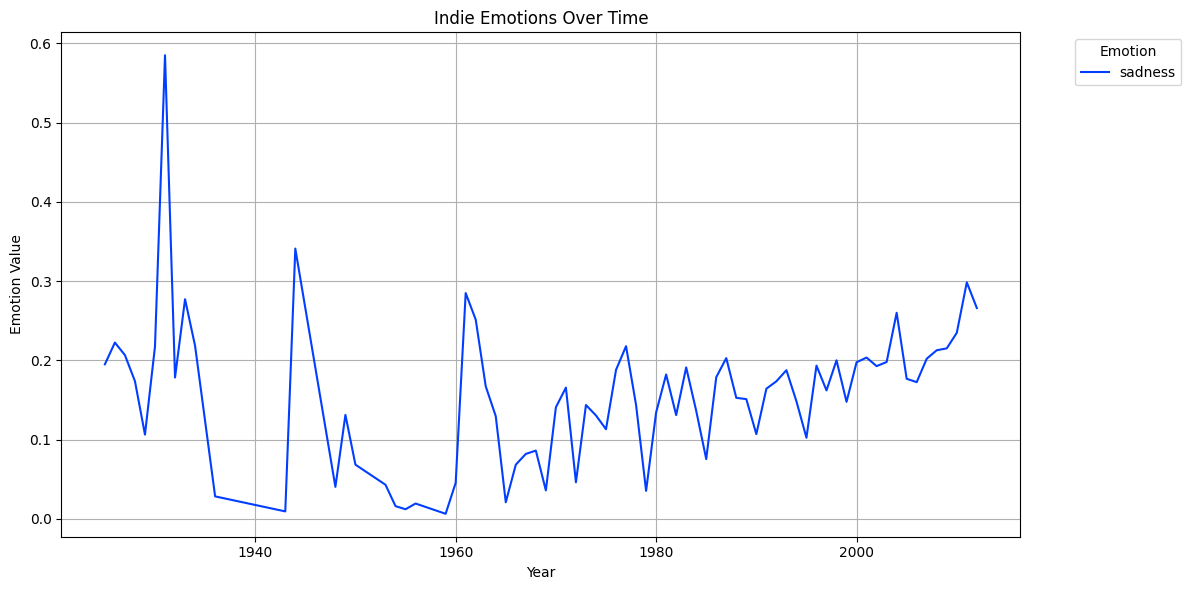

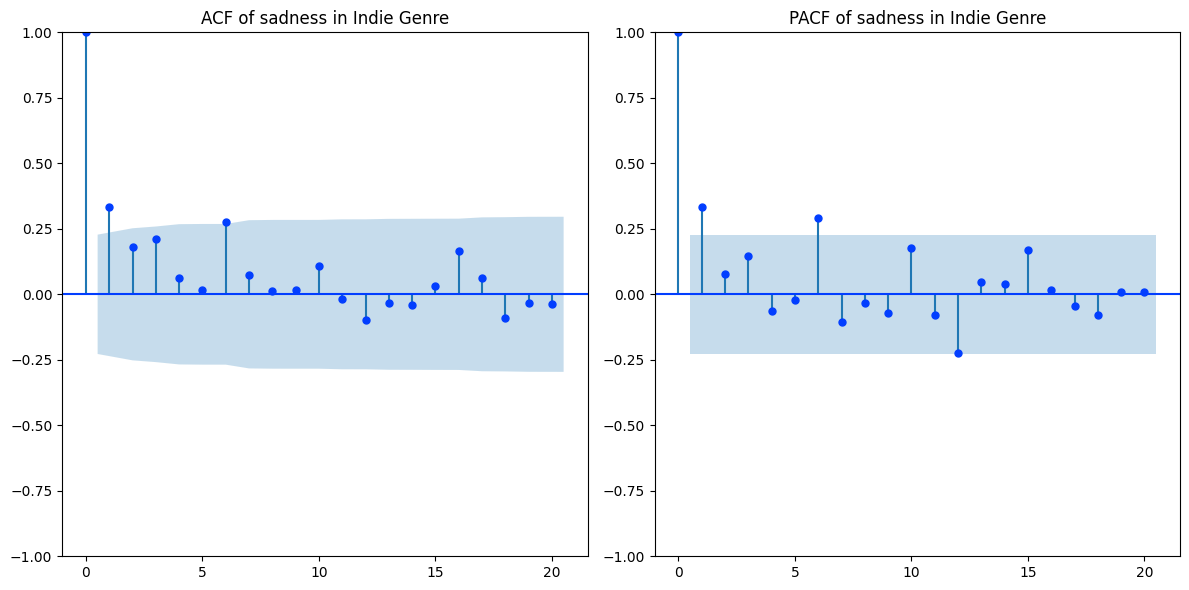

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.252380971271322
p-value: 0.0005365544557741419
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


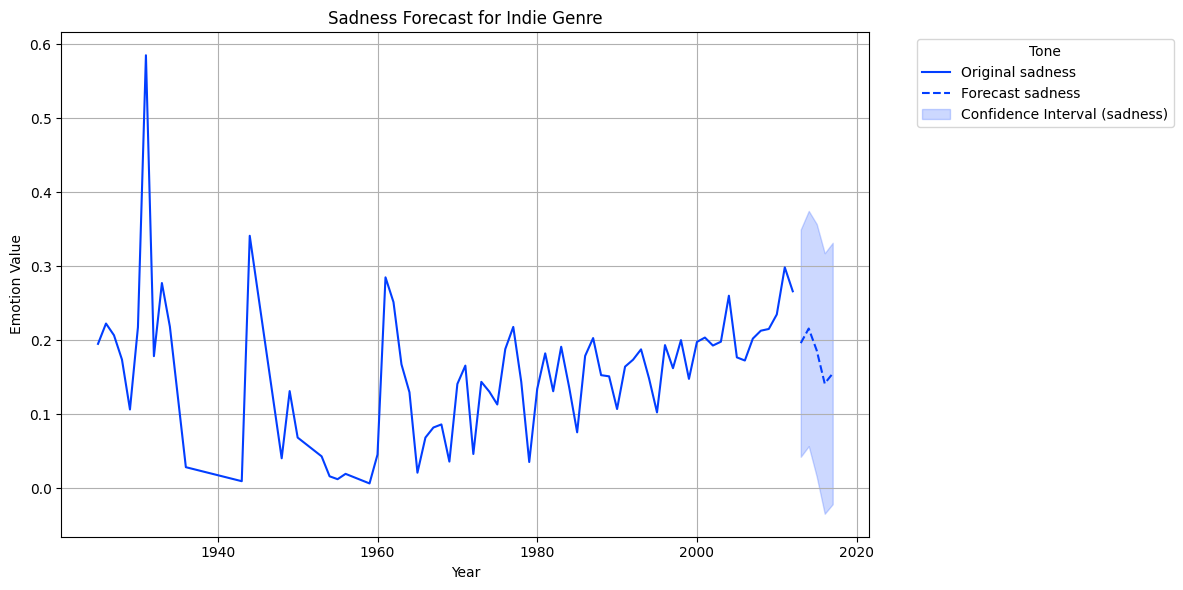

In [51]:
timeseries_plots(indie_df, "Indie")
indie_ts_results = box_jenkins_procedure(indie_df, "Indie")
indie_forecast_df = forecast_series(indie_df, "Indie", indie_ts_results)

## Romance movies Time Series Analysis 

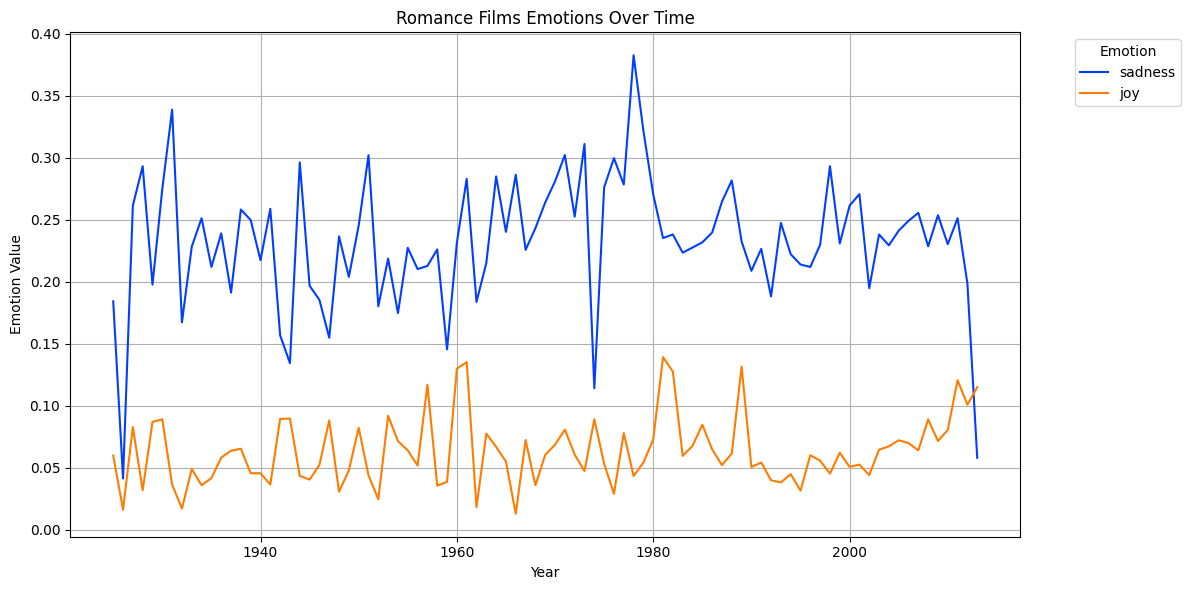

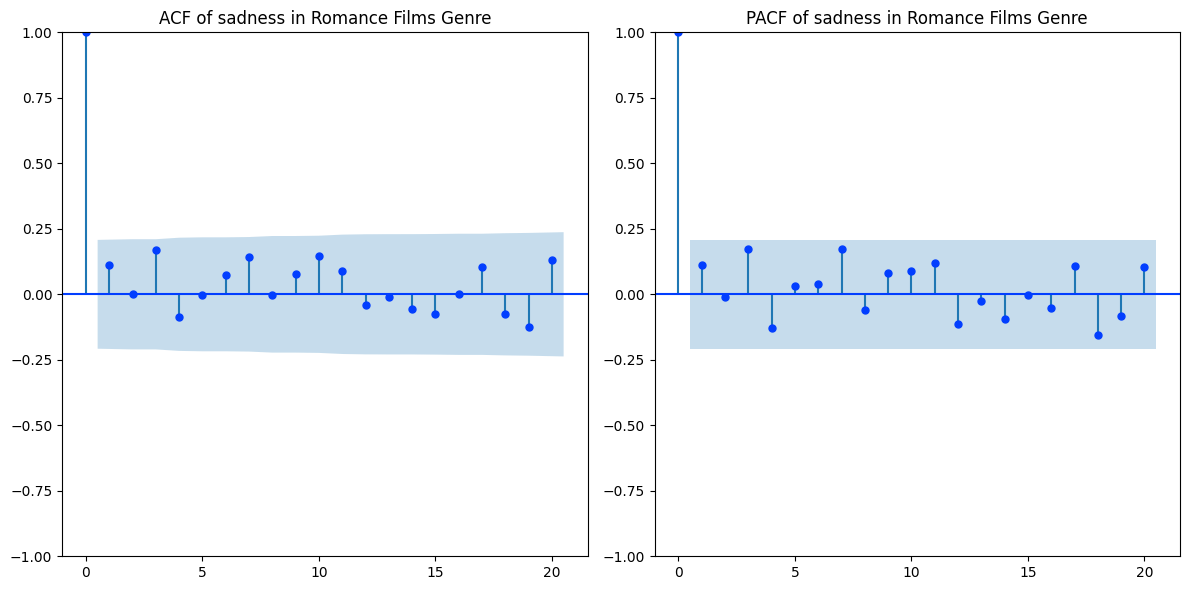

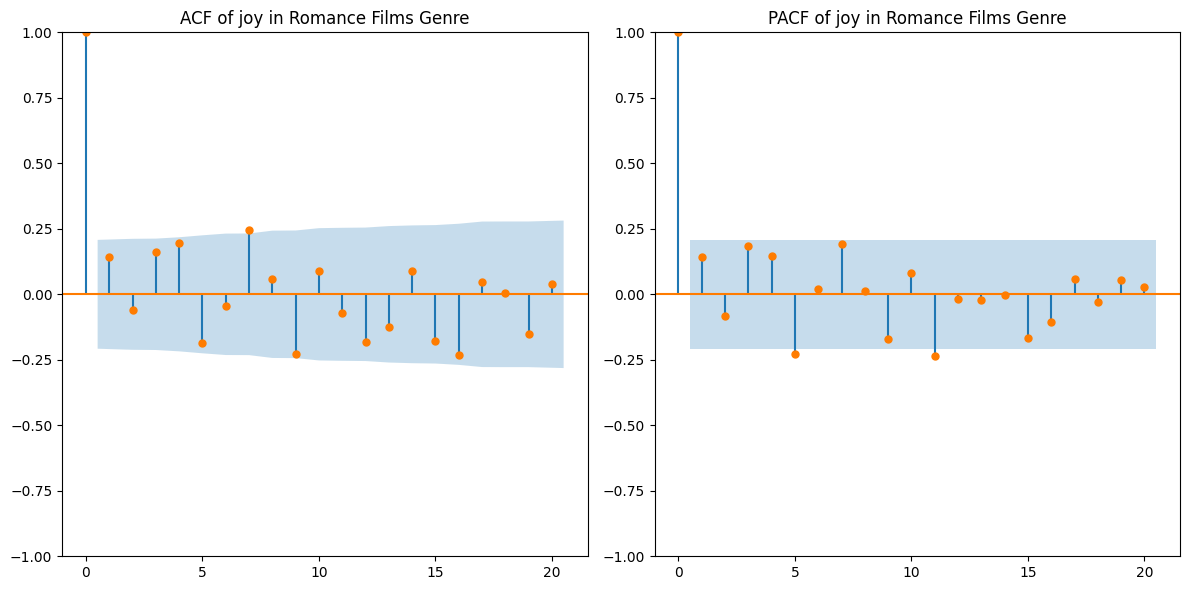

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -7.652981528121102
p-value: 1.769059577697513e-11
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.5113787418940445
p-value: 0.1127302444024218
The series is not stationary and needs to be differenced.
Best ARIMA Order for joy in Romance Film Genre: (3, 1, 1)


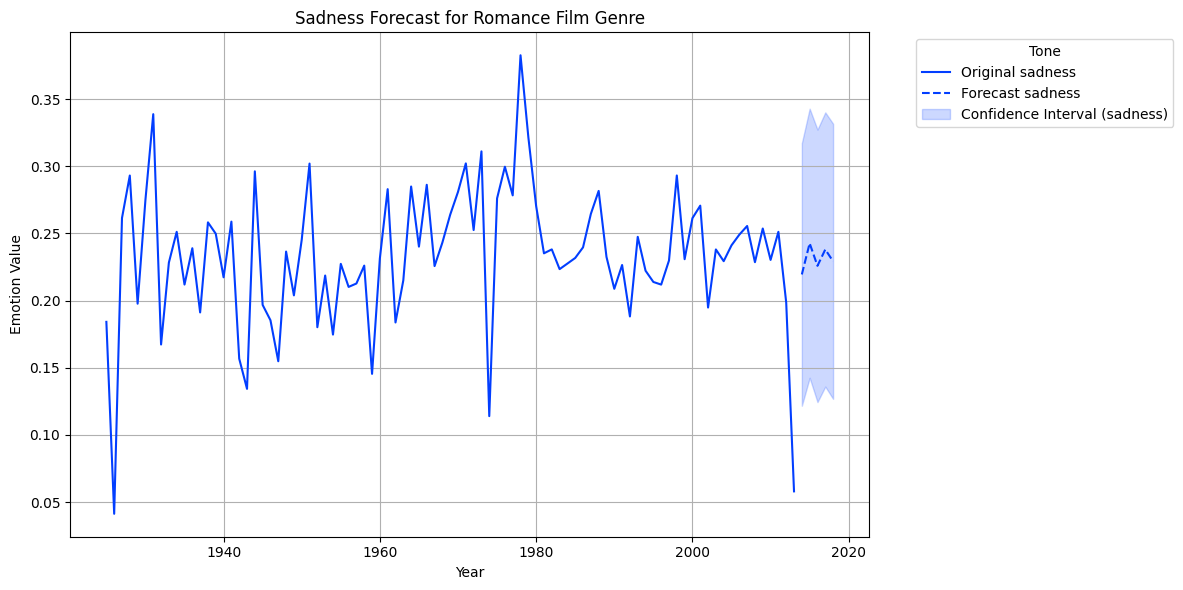

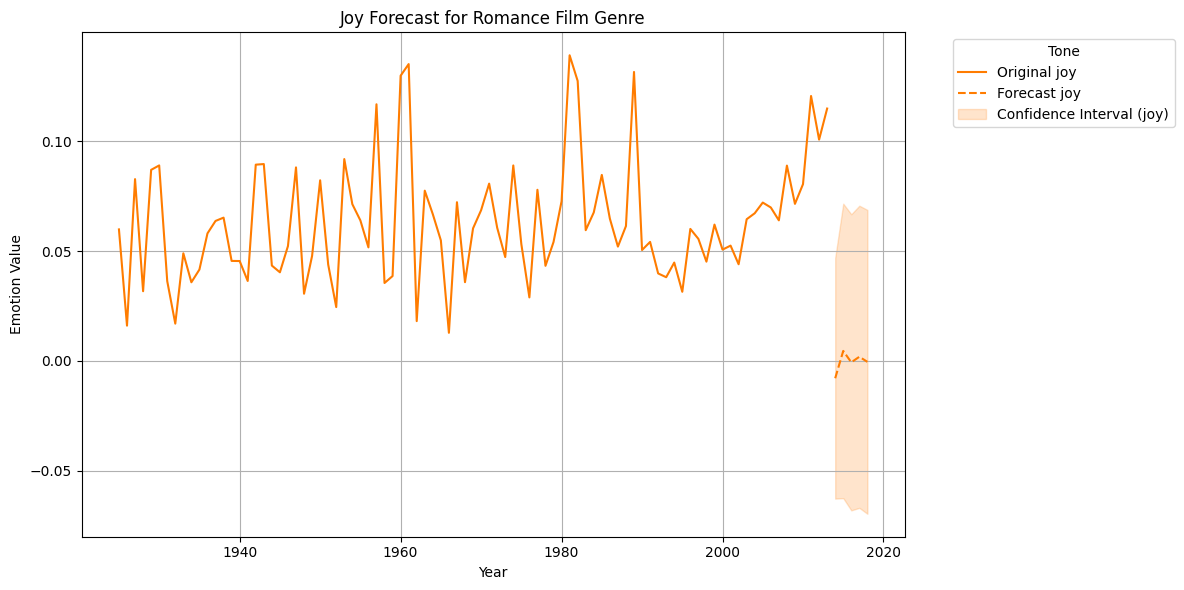

In [52]:
timeseries_plots(romance_film_df, "Romance Films")
romance_ts_results = box_jenkins_procedure(romance_film_df, "Romance Film")
romance_forecast_df = forecast_series(romance_film_df, "Romance Film", romance_ts_results)

## Thriller movies Time Series Analysis

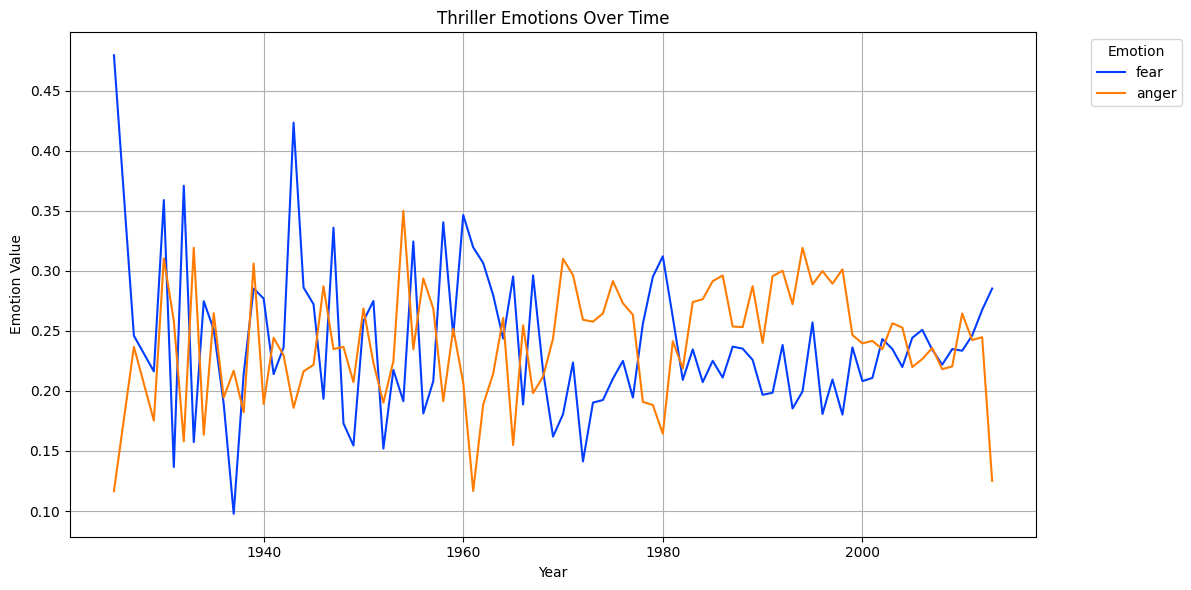

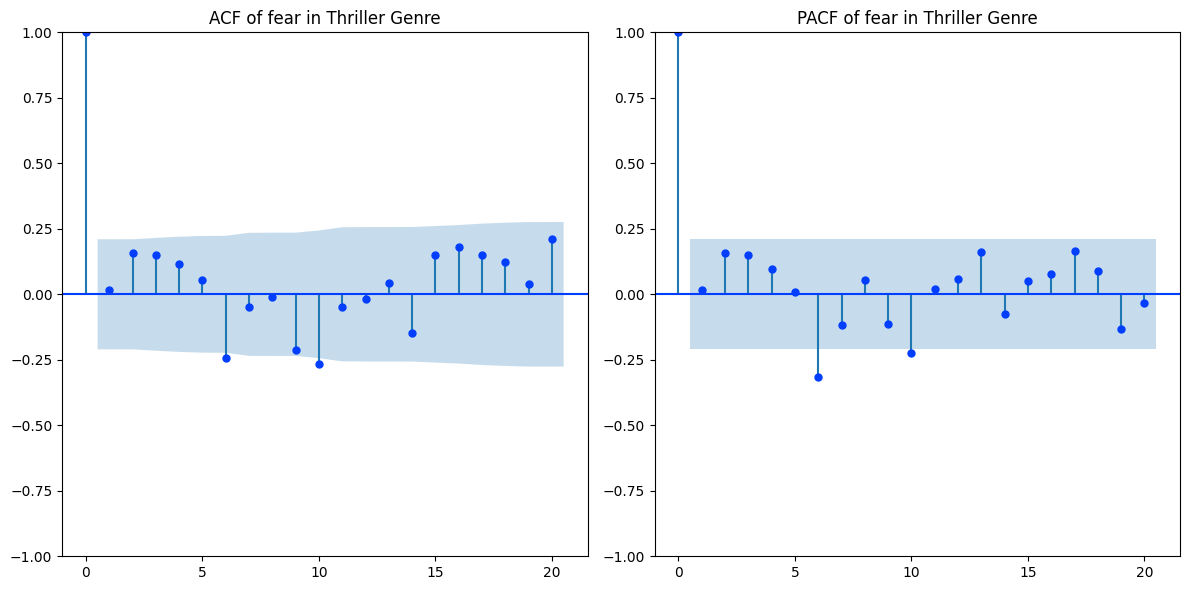

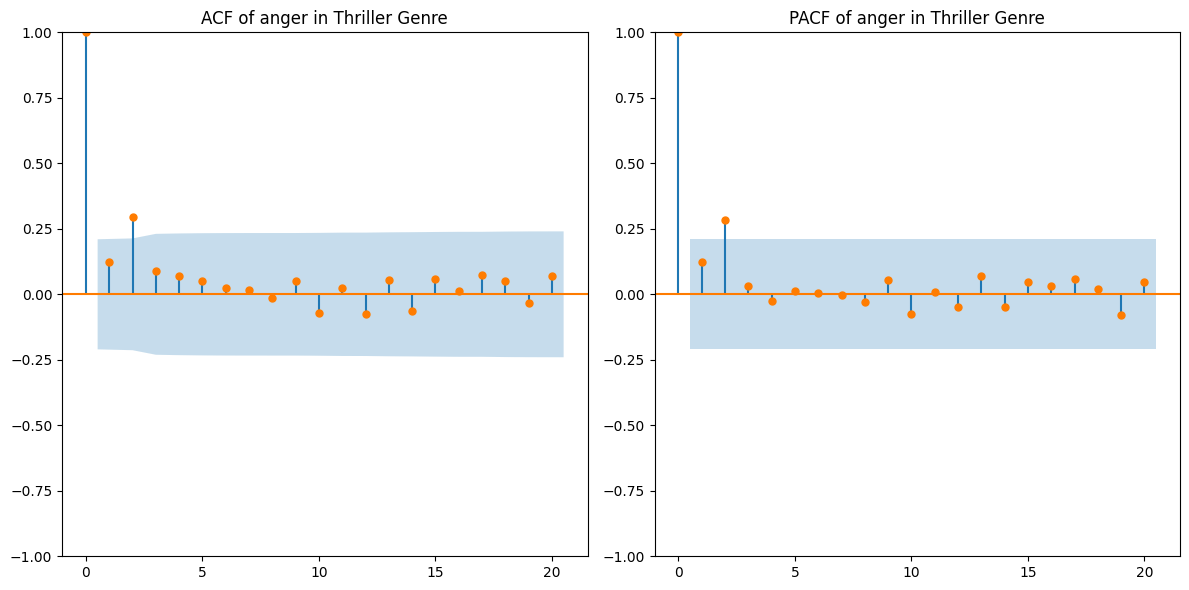

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.374850393030472
p-value: 0.0003287765337113442
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.267416270747676
p-value: 0.0005056040902271713
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


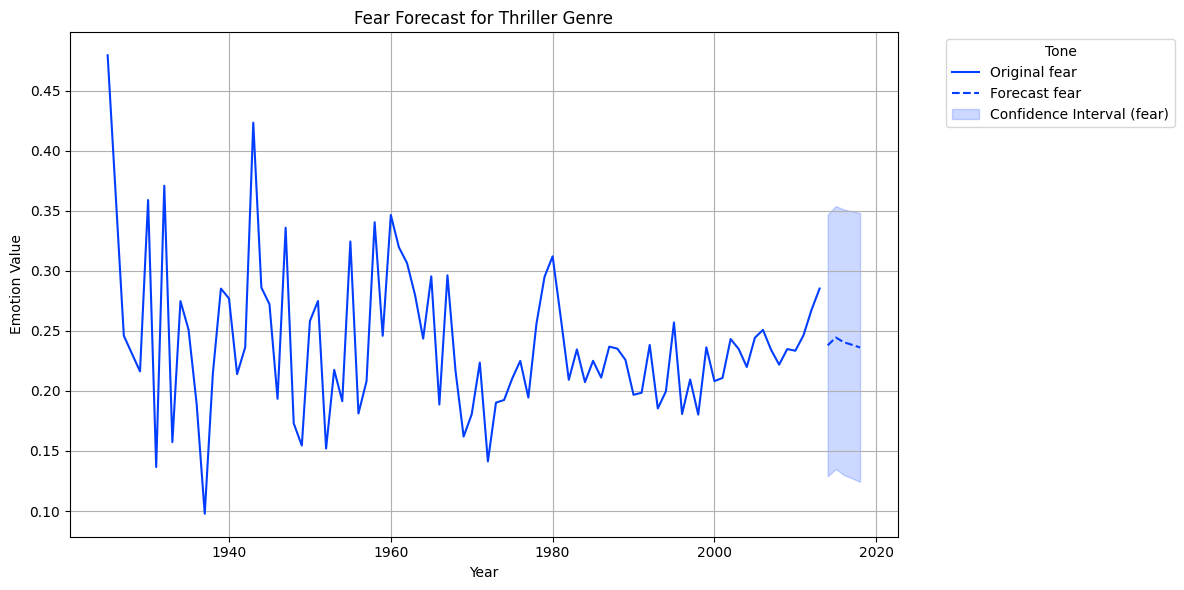

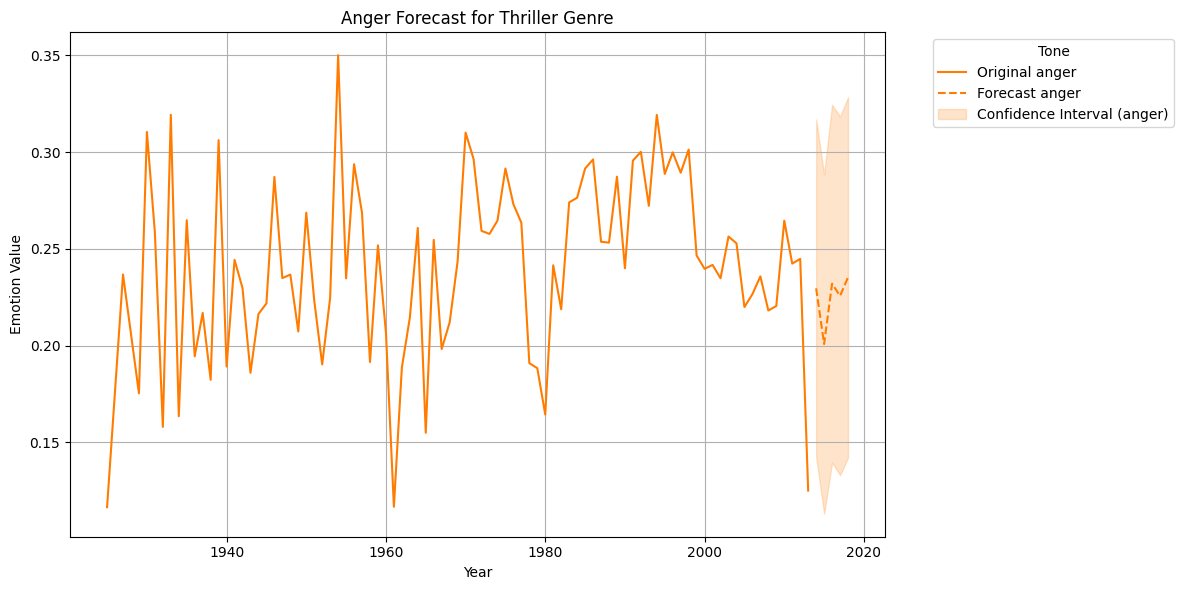

In [53]:
timeseries_plots(thriller_df, "Thriller")
thriller_ts_results = box_jenkins_procedure(thriller_df, "Thriller")
thriller_forecast_df = forecast_series(thriller_df, "Thriller", thriller_ts_results)

## World Cinema movies Time Series Analysis

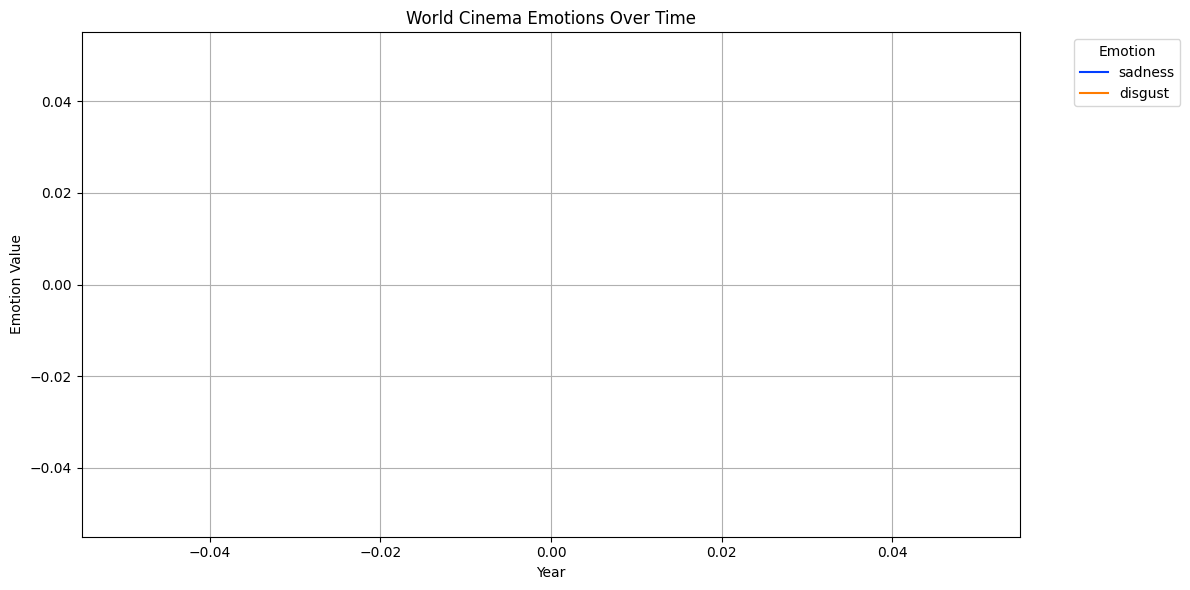

ValueError: negative dimensions are not allowed

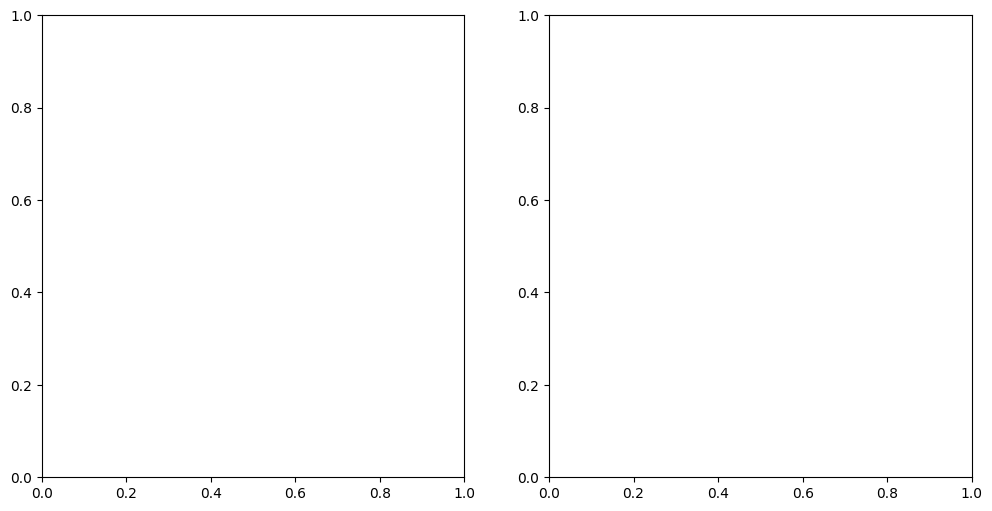

In [54]:
timeseries_plots(world_cinema_df, "World Cinema")
world_ts_results = box_jenkins_procedure(world_cinema_df, "World Cinema")
world_forecast_df = forecast_series(world_cinema_df, "World Cinema", world_ts_results)